## Starting line out predictor
This notebook explores creating a predictor to select a starting line-out that could be consistent through out the season. This is a good base to start a fantasy football team with then a starting line out optimiser can be used to update the team each week.

The data used for this will be the performance of each goal week of each player within the premiere league.

#### CURRENT CONSIDERATIONS:
- How can goalies be identified from this data set (position)
- How can rules for cost be set 

#### CURRENT LIMITATION:
- new players to the league (players from other leagues who are very strong players)

## Data Exploration and Data Cleaning
### Column assessment 
I will assess Marcus Rashford as he has been around since the 2016/17 season

In [27]:
#IMPORTED LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt

In [13]:

class Player:
    def __init__(self):
        self.player_name="Marcus_Rashford"

player = Player()

CSV_FILE_PATH = f'../data/2016-17/players/{player.player_name}/gw.csv'

player_16_17_df = pd.read_csv(CSV_FILE_PATH, encoding='latin1')


In [16]:
print(player_16_17_df.describe())

         assists  attempted_passes  big_chances_created  big_chances_missed  \
count  38.000000         38.000000            38.000000           38.000000   
mean    0.078947         14.368421             0.078947            0.105263   
std     0.273276         12.177563             0.273276            0.388307   
min     0.000000          0.000000             0.000000            0.000000   
25%     0.000000          5.250000             0.000000            0.000000   
50%     0.000000         11.500000             0.000000            0.000000   
75%     0.000000         24.750000             0.000000            0.000000   
max     1.000000         40.000000             1.000000            2.000000   

           bonus        bps  clean_sheets  clearances_blocks_interceptions  \
count  38.000000  38.000000     38.000000                        38.000000   
mean    0.052632   7.552632      0.184211                         0.447368   
std     0.324443   9.164259      0.392859             

In [21]:
print(player_16_17_df.dtypes[16:30])

fouls                       int64
goals_conceded              int64
goals_scored                int64
ict_index                 float64
id                          int64
influence                 float64
key_passes                  int64
kickoff_time               object
kickoff_time_formatted     object
loaned_in                   int64
loaned_out                  int64
minutes                     int64
offside                     int64
open_play_crosses           int64
dtype: object


In [9]:
print(player_16_17_df.columns)


Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards'],
      dtype='object')


##### Correlation Matrix
A correlation matrix was made to identify features of importance.
Kickoff_time columns were dropped as they had the wrong type for the correlation matrix

In [24]:
corr_df = player_16_17_df.drop(columns=['kickoff_time', 'kickoff_time_formatted'])

correlation_matrix = corr_df.corr()

correlation_with_total_points = correlation_matrix['total_points']

sorted_correlation = correlation_with_total_points.sort_values(ascending=False)
print(sorted_correlation)


total_points                       1.000000e+00
bps                                8.869388e-01
influence                          8.274598e-01
goals_scored                       7.706185e-01
ict_index                          7.563016e-01
target_missed                      6.273527e-01
minutes                            5.492437e-01
threat                             5.466956e-01
completed_passes                   5.464472e-01
bonus                              5.138995e-01
tackled                            5.006190e-01
attempted_passes                   4.951816e-01
winning_goals                      4.911923e-01
creativity                         4.852709e-01
recoveries                         4.836975e-01
dribbles                           3.960967e-01
key_passes                         3.683942e-01
assists                            3.559026e-01
goals_conceded                     2.923429e-01
clean_sheets                       2.122018e-01
fouls                              1.730

#### ICT Index

The ict index is a score provided by FPL which combines influence, threat and creativity. As influence and ICT score highly on the correlation matrix, it was investigated to decided whether it should be used instead of each individual set of scores.

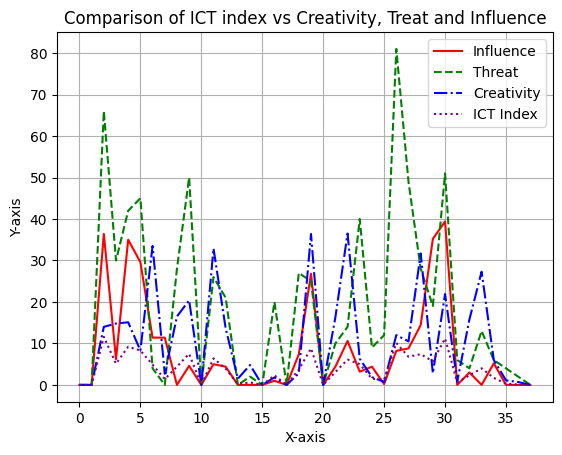

In [29]:
plt.plot(player_16_17_df['influence'], color='red', linestyle='-', label='Influence')
plt.plot(player_16_17_df['threat'], color='green', linestyle='--', label='Threat')
plt.plot(player_16_17_df['creativity'], color='blue', linestyle='-.', label='Creativity')
plt.plot(player_16_17_df['ict_index'], color='purple', linestyle=':', label='ICT Index')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of ICT index vs Creativity, Treat and Influence')
plt.legend()
plt.grid(True)
plt.show()

#### Consistency Matrix
A consistency matrix was considered for this model, made from how much the point difference differed

In [11]:
def get_consistency_index(df):
    minutes_weight = 0.6
    bonus_points_weight = 0.4

    df['minutes'] = (df['minutes'] - df['minutes'].mean()) / df['minutes'].std()
    df['bps'] = (df['bps'] - df['bps'].mean()) / df['bps'].std()

    consistency = minutes_weight * df['minutes'] + bonus_points_weight * df['bps']

    return consistency

consistency = get_consistency_index(player_16_17_df)

print(consistency)


0    -1.069148
1    -1.069148
2     0.437623
3     0.018663
4     1.412008
5     1.237049
6     1.150121
7     0.702087
8     0.539052
9     0.784157
10   -1.069148
11    0.713643
12   -0.062302
13   -0.806893
14   -0.669987
15   -1.019538
16   -0.708409
17   -1.069148
18   -0.495396
19    0.170878
20   -1.069148
21    0.116410
22    0.757291
23    0.364092
24   -0.774065
25   -0.724455
26    0.451756
27    0.844587
28    0.844587
29    0.596168
30    1.717175
31   -0.724455
32    0.626347
33    0.888234
34   -0.434966
35   -0.828533
36   -0.708041
37   -1.069148
dtype: float64
